In [20]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        self.n_features = X.shape[1]
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        #stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y) #jesli zostana dwie czy cos
            return Node(value=leaf_value)

        #losuje kolejnosc cech do sprawdzenia [0-3]
        feat_idxs = np.random.choice(n_features, self.n_features, replace=False)

        #index      #wartosc
        best_feat, best_thresh = self._best_split(X, y, feat_idxs)
        
        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:  #dla kazdej cechy | tak na prawde for i in range(4)
            X_column = X[:, feat_idx] #biore kolumne (konkretna ceche) np dlugosc szyjki
            thresholds = np.unique(X_column) 
            for threshold in thresholds: #dla kazdej wartosci w kolumnie
                gain = self._information_gain(y, X_column, threshold) ## np podzial dlugosc szyjki 3.2 < 

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        parent_entropy = self._entropy(y) 

        #dziele zbiory                         #konkretna wartosc
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0: ## to znaczy ze z jednej strony jest wszystko ig=0
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)  # ilosc probek
        n_l, n_r = len(left_idxs), len(right_idxs) #ilosc probek po podziale
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs]) #entropia po podziale
                                ##output class 1-3
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r #entropia po podziale

        # 
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten() #indeksy mniejsze od split_thresh
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y) #tablica wystapien konkreetnych klas 1-3
        ps = hist / len(y) #prawdopodobiensta kazdej klasy
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        #porownuje ceche z wartoscia w wezle np x to [1.2, 2.4, 0.4, 3.3] a node.feature to 2  node.threshold to 0.8
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def predict(self, X):   
        return np.array([self._traverse_tree(x, self.root) for x in  X])#tu bede mial tablice outputow ktore mi wyszly z predykcji

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

In [21]:
from sklearn import datasets 
from sklearn.model_selection import train_test_split 
import numpy as np

data = datasets.load_iris()

X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)
clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

def accuracy (y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

acc = accuracy(y_test, predictions)
print (acc)

1.0


In [12]:
def gini(samples):
    samples_sum = sum(samples)
    score = 0
    probs = []
    for s in samples:
        prob = s / samples_sum
        probs.append(prob)
    for p in probs:
        score += p * (1-p)
    return score


samples = [200, 75, 125] # 3 classes numer of elements
print(gini(samples))

# If we have a sample example with less uncertanity about which class it belongs to:
samples1 = [200, 0, 25] # 3 classes numer of elements
print(gini(samples1)) # Gini is getting smaller so LESS IMPURE sample in a potential Tree Node

samples2 = [200, 0, 0] # 3 classes numer of elements
print(gini(samples2))

0.6171875
0.1975308641975309
0.0


In [88]:
import math

def entropy(samples):
    samples_sum = sum(samples)
    score = 0
    probs = []
    for s in samples:
        prob = s / samples_sum
        probs.append(prob)
    for p in probs:
        if p > 0:
            score += p * math.log(p)
    if score != 0:
        score *= -1
    return score

samples = [200, 75, 125]
samples1 = [200, 0, 25]
samples2 = [200, 0, 0]
print(entropy(samples))
print(entropy(samples1))
print(entropy(samples2))

1.0239287996389363
0.34883209584303193
0.0


In [89]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np


iris_data = datasets.load_iris()
print(iris_data.keys())

print("Iris array shapes:\n")
print(f"Data shape: {iris_data.data.shape}")
print(f"Target shape: {iris_data.target.shape}\n")


dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
Iris array shapes:

Data shape: (150, 4)
Target shape: (150,)



In [90]:
print("Data content: \n")
print(iris_data.data[:3:])
print(np.unique(iris_data.target))
print(iris_data.target_names)

Data content: 

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]]
[0 1 2]
['setosa' 'versicolor' 'virginica']


In [91]:
X = iris_data.data[:, [2, 3]]   #data 
y = iris_data.target    #unique species

X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.2,
                         shuffle=True, random_state=123, stratify=y)

np.bincount(y_train) ##return array of occurence of each value in y_train

X_train, X_valid, y_train, y_valid = \
        train_test_split(X_train, y_train, test_size=0.2,
                         shuffle=True, random_state=123, stratify=y_train)

print('Train size', X_train.shape, 'class proportions', np.bincount(y_train))
print('Valid size', X_valid.shape, 'class proportions', np.bincount(y_valid))
print('Test size', X_test.shape, 'class proportions', np.bincount(y_test))
print(y_test)

Train size (96, 2) class proportions [32 32 32]
Valid size (24, 2) class proportions [8 8 8]
Test size (30, 2) class proportions [10 10 10]
[1 0 2 2 0 0 2 1 2 0 0 1 2 1 2 1 0 0 0 0 0 2 2 1 2 2 1 1 1 1]


In [92]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions


tree_clf = DecisionTreeClassifier(criterion='entropy',
                                  splitter='best',
                              max_depth=2,
                              random_state=1)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)

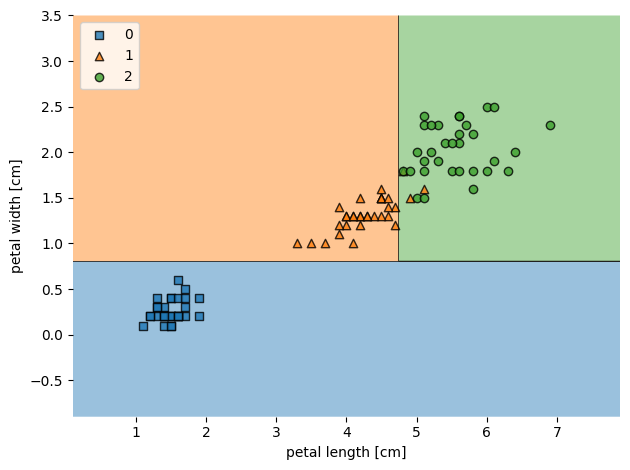

In [93]:
plot_decision_regions(X_train, y_train, tree_clf)

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [94]:
import pandas as pd

# np.c_ is the numpy concatenate function
iris_df = pd.DataFrame(data= np.c_[iris_data['data'], iris_data['target']],
                      columns= iris_data['feature_names'] + ['target'])

print(iris_df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  


In [95]:
group_names = pd.Series([iris_data.target_names[ind] for ind in iris_data.target], dtype = 'category')

iris_df['group'] = group_names


iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,group
0,5.1,3.5,1.4,0.2,0.0,setosa
1,4.9,3.0,1.4,0.2,0.0,setosa
2,4.7,3.2,1.3,0.2,0.0,setosa
3,4.6,3.1,1.5,0.2,0.0,setosa
4,5.0,3.6,1.4,0.2,0.0,setosa


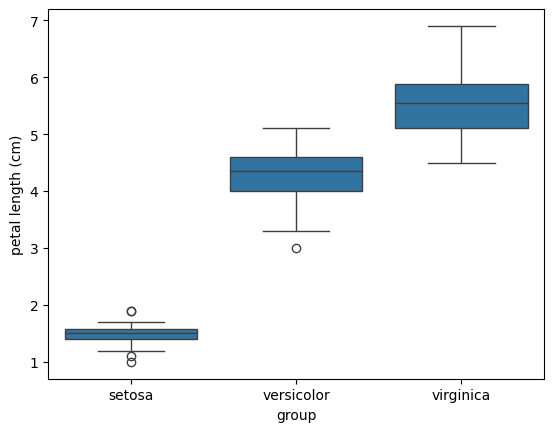

In [96]:
import seaborn as sns

import matplotlib.pyplot as plt

sns.boxplot(x="group",y="petal length (cm)",data=iris_df)

plt.show()

Text(0.5, 1.08, 'Pair Plot of the dataset without normalization')

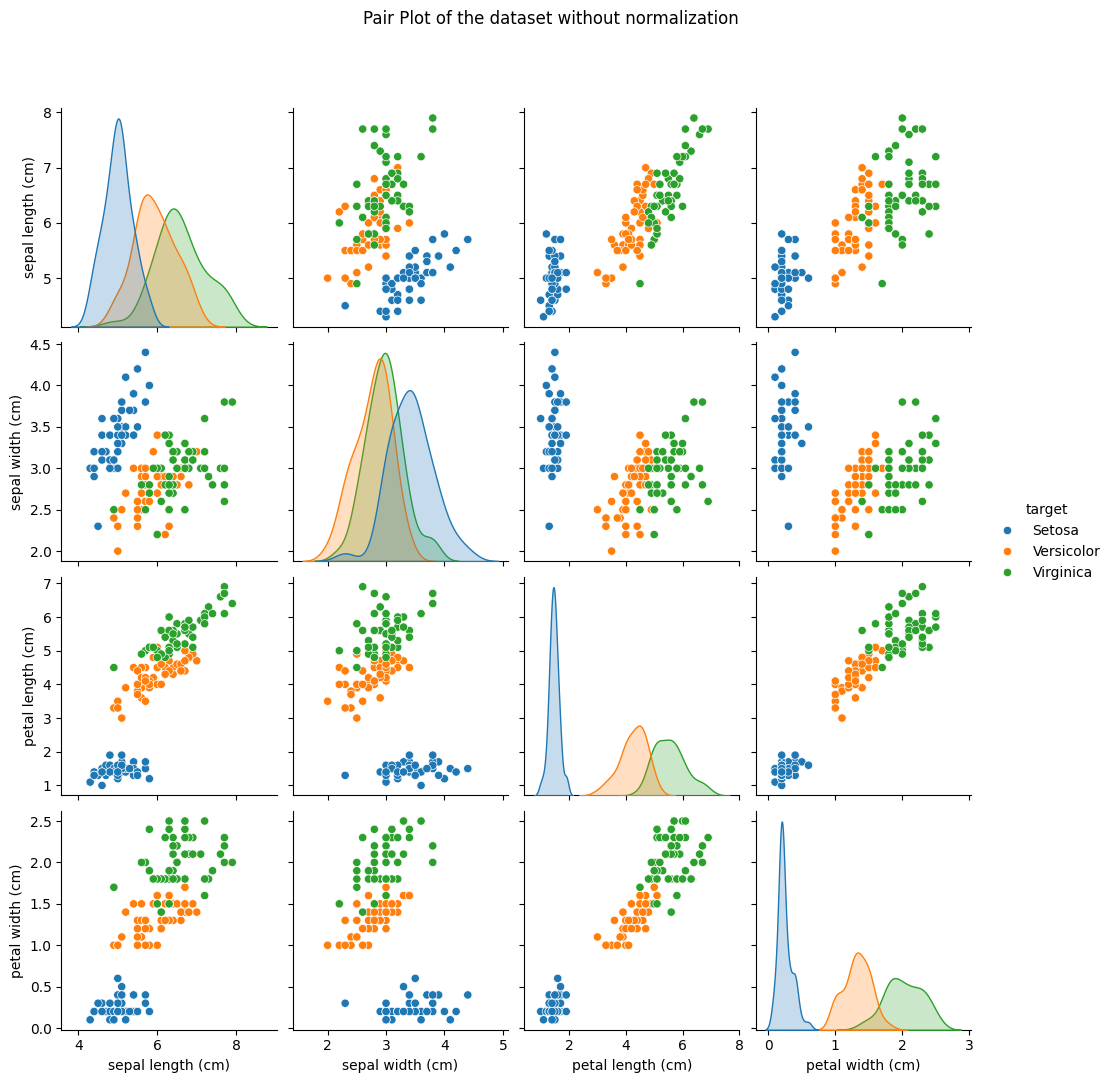

In [97]:
# View the relationships between variables; color code by species type
di= {0.0: 'Setosa', 1.0: 'Versicolor', 2.0:'Virginica'} # dictionary

before= sns.pairplot(iris_df.replace({'target': di}), hue= 'target')
before.figure.suptitle('Pair Plot of the dataset without normalization', y=1.08)

In [98]:
from sklearn import tree

text_representation = tree.export_text(tree_clf)
print(text_representation)

|--- feature_1 <= 0.80
|   |--- class: 0
|--- feature_1 >  0.80
|   |--- feature_0 <= 4.75
|   |   |--- class: 1
|   |--- feature_0 >  4.75
|   |   |--- class: 2



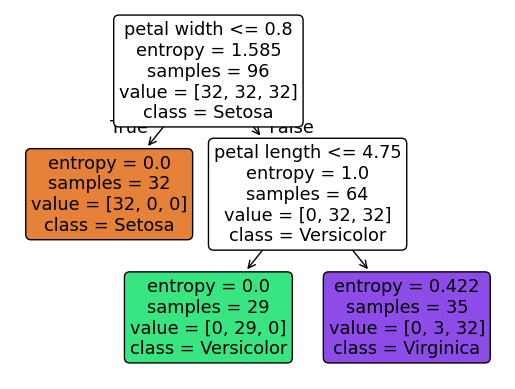

In [99]:
from sklearn.tree import plot_tree

plot_tree(tree_clf,
          filled=True,
          rounded=True,
          class_names=['Setosa', 'Versicolor', 'Virginica'],
          feature_names=['petal length', 'petal width'])

plt.show()

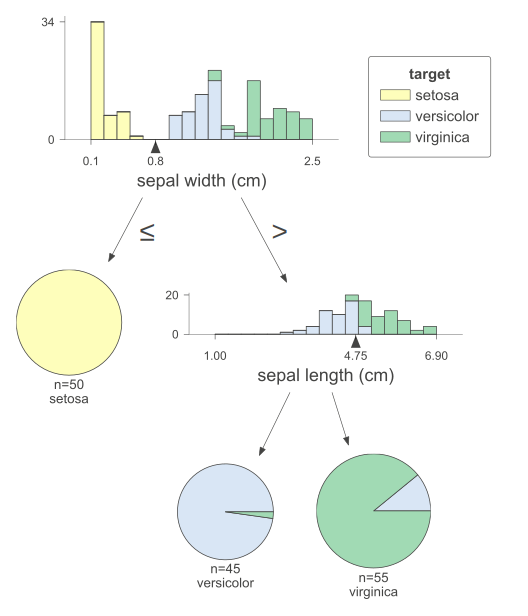

In [100]:
import dtreeviz  # remember to load the package

# Make sure tree_clf is defined or import it from a previous cell



viz_model = dtreeviz.model(tree_clf, X, y,
                target_name="target",
                feature_names=iris_data.feature_names,
                class_names=list(iris_data.target_names))

viz_model.view(scale=2.0)     # render as SVG into internal object

In [101]:
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import font_manager as fm, pyplot as plt

!wget https://github.com/matomo-org/travis-scripts/blob/master/fonts/Arial.ttf

font_files = fm.findSystemFonts()

# Go through and add each to Matplotlib's font cache.
for font_file in font_files:
    fm.fontManager.addfont(font_file)


t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2*np.pi*t)

plt.plot(t, s)

plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')
plt.title('About as simple as it gets, folks')
plt.show()

zsh:1: command not found: wget


KeyboardInterrupt: 